# PaintMate: AI-Powered Paint Estimator
### Capstone Project for Kaggle Gen AI Intensive Course 2025Q1
----

This project aims to help homeowners and contractors estimate painting requirements using a combination of Computer Vision and Generative AI (LLMs). Users can upload an image of an interior wall, and the tool will guide them through the estimation process, including dimensions, surface area, and paint volume required.

## Problem Statement

Estimating how much paint is needed for a renovation project often requires manual measurements, guesswork, or consultation with experts. This can be time-consuming, error-prone, or inaccessible for homeowners.

We propose a solution that combines computer vision (to identify the wall) and a language model (to guide the user, collect assumptions, and output a clear estimate), making this process fast, user-friendly, and AI-powered.

## Tools and Technologies

This project uses the following Gen AI capabilities:

- **Image understanding**: To describe and interpret wall images
- **Vector search / embedding** : For future enhancements or similarity search
- **Function calling / structured output**: To generate predictable responses
- **LangChain** or **agent orchestration**: To structure tasks

## Get started
### Set Gemini API, Libs and pip installs

In [2]:
!pip uninstall -y google-genai

In [3]:
!pip install -U -q "google-genai==1.7.0"

In [4]:
import os
import mimetypes
import typing_extensions as typing
from PIL import Image as PILImage
from google import genai
from google.genai import types
from IPython.display import HTML, Markdown, display
from kaggle_secrets import UserSecretsClient
import json

In [5]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

In [6]:
import pkg_resources
print(pkg_resources.get_distribution("google-genai").version)

1.7.0


### Configure API Key

> ⚠️ To run this notebook with live Gemini API calls, you must:
> - Have a Google Cloud project with Gemini API enabled
> - Add your API key as a Kaggle Secret named `GOOGLE_API_KEY`
> - Enable necessary billing or free-tier access

In [7]:
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

## Load the dataset

> **Important**: This notebook uses a custom dataset called `interior-wall-samples`.
>
> To run this notebook correctly:
> 1. On the right sidebar, go to **Add-ons** → **+ Add Dataset**
> 2. Search for **`interior-wall-samples`** (you uploaded it)
> 3. Click **"Add"** to attach it.

In [8]:
# Path where the dataset should be mounted
image_dir = "/kaggle/input/interior-wall-samples"

# Check for dataset availability
if not os.path.exists(image_dir):
    raise FileNotFoundError(
        f"Dataset not found! Please make sure to attach the dataset 'interior-wall-samples' "
        f"to this notebook using the right sidebar 'Add-ons' > 'Dataset' > search and add it."
    )

### Upload Example Images

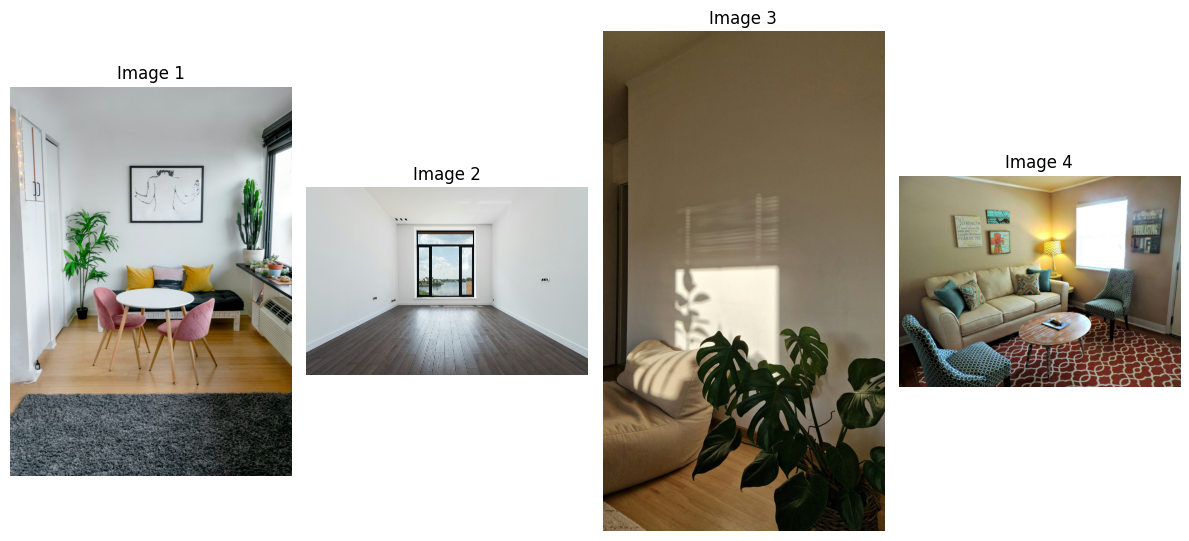

In [9]:
import matplotlib.pyplot as plt

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))])

n_images = 4
plt.figure(figsize=(12, 6))
for i in range(n_images):
    img_path = os.path.join(image_dir, image_files[i])
    img = PILImage.open(img_path)
    plt.subplot(1, n_images, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()

## 1. Scene Understanding with a Multimodal LLM

We simulate the behavior of a multimodal large language model (LLM) Google Gemini Pro Vision to describe the uploaded image and extract relevant information for estimating paint needs.

The LLM provides:
- A natural language description of the room
- Reasoned assumptions based on object scale
- An estimated height and width of the wall

> **GenAI Capabilities demonstrated**: Image Understanding + Structured Output (JSON mode)

### Provide a "few-shot" prompt (which includes multiple examples):

In [10]:
prompt = """
You are a virtual renovation assistant. Based on the uploaded image, describe the room and estimate the wall dimensions using visible reference objects (e.g., table, chair, window).

Your response must strictly follow the JSON structure below. Avoid extra assumptions and keep the output concise.

JSON format:
{
  "description": "...",                 // Brief, clear natural language description of the room
  "assumptions": ["..."],              // Max 5 concise assumptions (1 line each)
  "estimated_dimensions": {
    "height": float,                 // Approximate wall height in feet
    "width": float,                  // Approximate wall width in feet
    "area": float                   // Estimated wall area in square feet
  }
}

JSON Response:
```
{
  "description": "The image shows a living room with off-white walls, light beige carpeting, and a mid-century modern aesthetic.  Furnishings include a green couch with orange and beige pillows, a wooden coffee table, two light-colored armchairs with dark wood frames, a gold arc lamp, two framed abstract prints, and two potted plants.",
  "assumptions": [
    "Standard ceiling height of 2.4 meters",
    "The sofa is approximately 2 meters long.",
    "The chairs are approximately 0.8 meters wide."
  ],
  "estimated_dimensions": {
    "height": 9,
    "width": 14,
    "area": 31
  }
}
```

JSON Response:
```
{
  "description": "The image shows a room with mustard-yellow walls, a dark wood-look floor, and white baseboards.  A wooden bench sits against the far wall, holding framed art prints, a large clear glass vase with bare branches, and a potted plant.  A partially visible dining table and a white, furry chair are on the left side of the image. A white, pleated pendant lamp hangs from the ceiling.  A potted yucca plant is to the left of the bench, and another plant is on the bench.",
  "assumptions": [
    "Standard ceiling height of approximately 2.4 meters.",
    "The bench is approximately 1 meter long.",
    "The framed prints are standard sizes."
  ],
  "estimated_dimensions": {
    "height": 9,
    "width": 14,
    "area": 30
  }
}
```
JSON Response:
```
{
  "description": "The image depicts an empty room with white walls and light wooden flooring.  A wooden ladder leans against the left wall, while a white bar stool and a potted snake plant sit near the center of the room. A large, bright window is visible on the right wall, filling the space with natural light.",
  "assumptions": [
    "Standard ladder height of approximately 2.5 meters.",
    "Standard bar stool height of approximately 0.75 meters."
  ],
  "estimated_dimensions": {
    "height": 8,
    "width": 19,
    "area": 47
  }
}
```


"""

### Define the JSON Schema

In [11]:
class EstimatedDimensions(typing.TypedDict):
    height: float
    width: float
    area: float

class Wall(typing.TypedDict):
    description: str
    assumptions: list[str]
    estimated_dimensions: EstimatedDimensions

### Select and display one of the dataset images to compare it with the generated JSON:

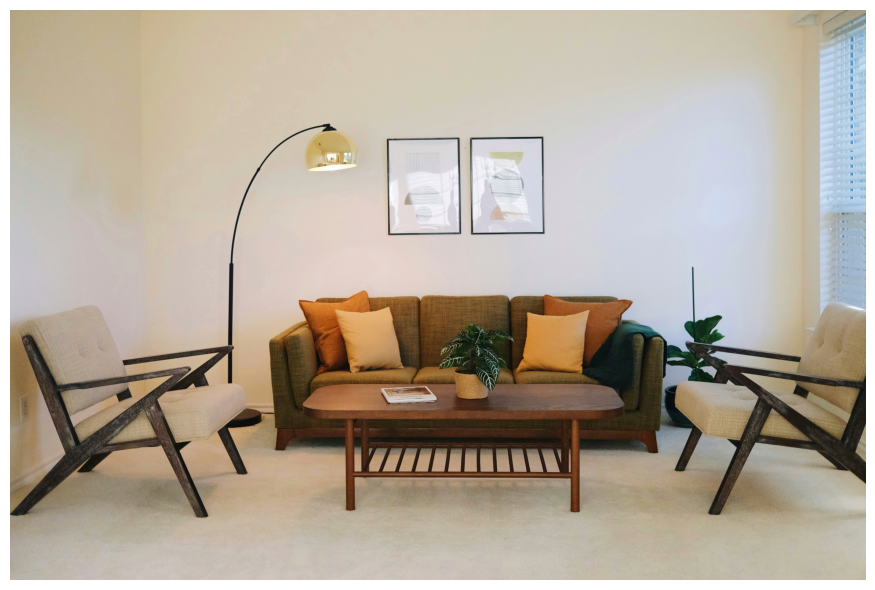

In [12]:
image = PILImage.open(os.path.join(image_dir, 'img6.jpg'))   # <-- try other images!

plt.figure(figsize=(12, 6))
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
client = genai.Client(api_key=GOOGLE_API_KEY)
response = client.models.generate_content(
    model="models/gemini-2.0-flash", #"models/gemini-1.5-pro-latest",
    config=types.GenerateContentConfig(
        temperature=0.1, response_mime_type="application/json", response_schema=Wall),
    contents=[prompt, image]
)
print("\nJSON Output:\n")
print(json.dumps(response.parsed, indent=2, ensure_ascii=False))


JSON Output:

{
  "description": "The image shows a living room with off-white walls, light beige carpeting, and a mid-century modern aesthetic. Furnishings include a green couch with orange and beige pillows, a wooden coffee table, two light-colored armchairs with dark wood frames, a gold arc lamp, two framed abstract prints, and two potted plants.",
  "assumptions": [
    "Standard ceiling height of 2.4 meters.",
    "The sofa is approximately 2 meters long.",
    "The chairs are approximately 0.8 meters wide."
  ],
  "estimated_dimensions": {
    "height": 8.0,
    "width": 14.0,
    "area": 112.0
  }
}


### The kind of output we hoped for! The model is generating structured, reasoned, and visually aware responses using Gemini with image input, assumptions, and dimension estimation.

## 2. Build an Agent

We leverage the Function Calling capabilities of Gemini to estimate how much paint is needed for a renovation project based on the dimensions extracted in the previous step.

This step uses a custom-defined function, `calculate_paint`, which takes the wall area, number of coats, and paint coverage efficiency as inputs. Gemini automatically detects when to invoke the function and returns a structured, actionable result.

The function:
- Multiplies the area by the number of coats
- Divides by the coverage rate (m² per liter)
- Outputs the total amount of paint required in liters

> **GenAI Capabilities demonstrated**: Function Calling + Structured Output (JSON mode)

In [14]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 7.9 MB/s eta 0:00:00


### 2.1 Build a chatbot as the first Node and main State

In [16]:
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

class PaintPilotState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    image_path: str                # assumes 1 image at a time — fine for now
    scene_info: dict              # structured JSON describing the room
    estimation: dict              # final paint calculation
    finished: bool                # has the flow been completed

# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
PAINTPILOT_SYSINT = (
    "system",
    "You are PaintPilotBot, a virtual assistant that helps users estimate how much paint is needed to paint a wall or room. "
    "The user will upload an image of a room, and you will: "
    "- Describe the scene using visual elements in the image. "
    "- Estimate wall dimensions using references like furniture or windows. "
    "- Calculate the paint needed (in gallons and liters), considering coverage and number of coats. "
    "- If the user asks, allow for refinements (e.g. number of coats, exclude windows, change material). "
    "- Once the user confirms, suggest a final list of painting products and tools for the job."
    "\n\n"
    "You are only focused on the painting process and should not answer unrelated questions. "
    "If any of the tools (like estimation or product list generation) are unavailable, you may inform the user that "
    "they have not been implemented yet and should continue developing the assistant."
)

WELCOME_MSG = (
    "Welcome to PaintPilotBot! I’ll help you estimate how much paint you need to paint your wall or room. "
    "Please upload a photo of the space you want to paint. Type `q` to quit anytime."
)

In [17]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [PAINTPILOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph = StateGraph(PaintPilotState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph.add_edge(START, "chatbot")

chat_graph = graph.compile()

NameError: name 'OrderState' is not defined

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage


def chatbot_node(state: PaintMateState) -> PaintMateState:
    messages = state["messages"]
    last_user_msg = messages[-1].content.lower()

    if state.get("estimation") and len(state["estimation"]) > 0:
        est = state["estimation"][-1]
        reply = (
            f"Estimated paint needed: {est['paint_gallons']} gallons "
            f"({est['paint_liters']} liters) for {est['area_ft2']} ft² "
            f"({est['area_m2']} m²), {est['coats']} coats, "
            f"{est['coverage_ft2_gal']} ft²/gal coverage ({est['coverage_m2_l']} m²/L)."
        )

    elif state.get("scene_info") and len(state["scene_info"]) > 0:
        formatted = json.dumps(state["scene_info"][-1], indent=2, ensure_ascii=False)
        reply = f"Here’s the scene analysis in JSON format:\n```json\n{formatted}\n```"

    elif "wall" in last_user_msg or "paint" in last_user_msg:
        reply = (
            "Great! Please upload a photo of the wall you'd like to paint. "
            "I’ll analyze it and estimate the amount of paint needed."
        )

    else:
        reply = (
            "Hi! I'm PaintMate. I can help estimate how much paint you need for your wall. "
            "Just upload a photo to get started."
        )

    return {
        **state,
        "messages": messages + [AIMessage(content=reply)]
    }





# def chatbot_node(state: PaintMateState) -> PaintMateState:
#     messages = state["messages"]
#     last_user_msg = messages[-1].content.lower()

#     if "wall" in last_user_msg or "paint" in last_user_msg:
#         reply = (
#             "Great! Please upload a photo of the wall you'd like to paint. "
#             "I’ll analyze it and estimate the amount of paint needed."
#         )
#     else:
#         reply = "Hi! I'm PaintMate. I can help estimate how much paint you need for your wall. Just upload a photo to get started."

#     return {"messages": messages + [AIMessage(content=reply)]}


In [ ]:
def print_chat(messages):
    for msg in messages:
        if isinstance(msg, BaseMessage):
            role = "User" if msg.type == "human" else "PaintMate"
            print(f"{role.ljust(9)}: {msg.content}")
        else:
            print("Skipping invalid message:", msg)


### Test the State and first Node:

In [ ]:
initial_state = {
    "messages": [HumanMessage(content="Hi, I want to paint my living room")],
    "image_path": [],
    "scene_info": {},
    "estimation": {}
}

result = chatbot_node(initial_state)
print_chat(result["messages"])


### 2.2 Add the 'Scene Analysis'

In [ ]:
image = PILImage.open(os.path.join(image_dir, 'img6.jpg'))
client = genai.Client(api_key=GOOGLE_API_KEY)

def scene_analysis(state, prompt, image, client):
    response = client.models.generate_content(
        model="models/gemini-1.5-pro-latest",
        config=types.GenerateContentConfig(
            temperature=0.1,
            response_mime_type="application/json",
            response_schema=Wall
        ),
        contents=[prompt, image]
    )

    parsed = response.parsed  # typed as Wall
    formatted = json.dumps(parsed, indent=2, ensure_ascii=False)

    return {
        **state,
        "scene_info": parsed,  
        "messages": state["messages"] + [
            AIMessage(content=f"Here’s the scene analysis in JSON format:\n```json\n{formatted}\n```")
        ]
    }


In [ ]:
from langchain_core.runnables import RunnableLambda

scene_analysis_node = RunnableLambda(lambda state: scene_analysis(state, prompt, image, client))


In [ ]:
from langgraph.graph import StateGraph

class PaintEstimatorState(typing.TypedDict):
    messages: list
    
graph = StateGraph(PaintMateState)

graph.add_node("chatbot", chatbot_node)
graph.add_node("scene_analysis", scene_analysis_node)

graph.set_entry_point("chatbot")
graph.set_finish_point("scene_analysis")

graph.add_edge("chatbot", "scene_analysis") 

app = graph.compile()


In [ ]:
initial_state = {
    "messages": [HumanMessage(content="Hi, I want to paint this wall!")],
    "image_path": [],
    "scene_info": [],
    "estimation": []
}

result = app.invoke(initial_state)
print_chat(result["messages"])


### Nice. The Agent is reproducing the same answer that we got directly from Gemini.

### 2.3 Add the 'Paint Estimator' 

In [ ]:
import re
import json
from langchain_core.messages import HumanMessage, AIMessage

def paint_estimator(state: PaintMateState) -> PaintMateState:
    try:
        dims = state["scene_info"]["estimated_dimensions"]

        area_ft2 = dims["area"]
        coats = 2
        coverage_m2_l = 10.0
        paint_liters = (area_ft2 * coats) / coverage_m2_l

        converted = convert_to_us_units(
            area_ft2=area_ft2,
            paint_liters=paint_liters,
            coats=coats,
            coverage_m2_l=coverage_m2_l
        )

        summary = (
            f"Estimated paint needed: {converted['paint_gallons']} gallons ({converted['paint_liters']} liters) "
            f"for {converted['area_ft2']} ft² ({converted['area_m2']} m²), {converted['coats']} coats, "
            f"{converted['coverage_ft2_gal']} ft²/gal coverage ({converted['coverage_m2_l']} m²/L)."
        )

        return {
            **state,
            "estimation": converted,  
            "messages": state["messages"] + [AIMessage(content=summary)]
        }

    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [
                AIMessage(content=f"Paint estimate failed: {str(e)}")
            ]
        }



def convert_to_us_units(area_ft2: float, paint_liters: float, coats: int, coverage_m2_l: float) -> dict:
    area_m2 = area_ft2 / 10.764
    paint_gallons = paint_liters / 3.78541
    coverage_ft2_gal = round(coverage_m2_l * 10.764 * 3.78541, 1)

    return {
        "area_ft2": round(area_ft2, 2),
        "area_m2": round(area_m2, 2),
        "paint_gallons": round(paint_gallons, 2),
        "paint_liters": round(paint_liters, 2),
        "coats": coats,
        "coverage_ft2_gal": coverage_ft2_gal,
        "coverage_m2_l": coverage_m2_l
    }


In [ ]:
paint_estimator_node = RunnableLambda(paint_estimator)

graph.add_node("paint_estimator", paint_estimator_node)



In [ ]:
graph.add_edge("scene_analysis", "paint_estimator")
graph.set_finish_point("paint_estimator")  # since it's the last new node

In [ ]:
app = graph.compile()

initial_state = {
    "messages": [HumanMessage(content="Hi, I want to paint this wall!")],
    "image_path": [],
    "scene_info": [],
    "estimation": []
}

result = app.invoke(initial_state)
print_chat(result["messages"])



### 2.4 Add the Refinement Q&A Node
We'll create a function that checks the last user message and returns a tailored response if they:
- ask for more coats
- mention a window
- ask about wall material

In [ ]:
def refinement_qna(state: PaintMateState) -> PaintMateState:
    messages = state["messages"]
    last_msg = messages[-1].content.lower()

    if "coat" in last_msg:
        reply = "Sure! Let me recalculate for more coats. How many coats do you want to apply?"
    elif "window" in last_msg:
        reply = "Good catch! If there's a window, you can subtract about 15 ft² from the wall area. Would you like me to recalculate?"
    elif "material" in last_msg or "brick" in last_msg or "drywall" in last_msg:
        reply = "Different materials may require primers or more coats. We assume standard drywall by default. Would you like to specify another material?"
    else:
        reply = "Let me know if you'd like to adjust wall dimensions, paint coats, or subtract any elements like windows or doors."

    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=reply)]
    }


In [ ]:
refinement_qna_node = RunnableLambda(refinement_qna)

In [ ]:
# Final LangGraph build (after all nodes are defined)
#graph = StateGraph(PaintMateState)

graph.add_node("refinement_qna", refinement_qna_node)
graph.add_edge("paint_estimator", "refinement_qna")
graph.add_edge("refinement_qna", "chatbot")  # loops back to continue conversation
graph.set_finish_point("chatbot")  # chatbot is the new final node

# # Add nodes
# graph.add_node("chatbot", chatbot_node)
# graph.add_node("scene_analysis", scene_analysis_node)
# graph.add_node("paint_estimator", paint_estimator_node)
# graph.add_node("refinement_qna", refinement_qna_node)

# # Edges (linear logic with central routing)
# graph.add_edge("chatbot", "scene_analysis")
# graph.add_edge("scene_analysis", "paint_estimator")
# graph.add_edge("paint_estimator", "chatbot")
# graph.add_edge("chatbot", "refinement_qna")  # optional follow-up Q&A
# graph.add_edge("refinement_qna", "chatbot")  # loop back for more clarification
# graph.add_edge("chatbot", "__end__")         # finish when no next action

# # Entry and exit
# graph.set_entry_point("chatbot")
# graph.set_finish_point("chatbot")

# # Compile
app = graph.compile()

In [ ]:
from IPython.display import Markdown

Markdown(f"""```mermaid
%%{{init: {{'theme': 'default'}} }}%%
{app.get_graph().draw_mermaid()}""")

### Test

In [ ]:
# Compile the graph
app = graph.compile()

# Start conversation
initial_state = {
    "messages": [HumanMessage(content="Hi, I want to paint this wall!")],
    "image_path": [],          
    "scene_info": [],          
    "estimation": []           
}

result = app.invoke(initial_state)

# better-print chat history
def print_chat(messages):
    for msg in messages:
        if hasattr(msg, "type") and hasattr(msg, "content"):
            role = "User" if msg.type == "human" else "PaintMate"
            print(f"{role.ljust(9)}: {msg.content}")
        else:
            print("Skipping invalid message:", msg)

print_chat(result["messages"])



In [ ]:
# Optional: peek into state
print("\n🧠 Scene Info:")
print(json.dumps(result.get("scene_info", []), indent=2, ensure_ascii=False))

print("\n🎯 Estimation:")
print(json.dumps(result.get("estimation", []), indent=2, ensure_ascii=False))


In [ ]:
# Define the state schema
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.tools import tool
from langchain_core.runnables import RunnableMap
#from langchain_core.state import State

class PaintEstimatorState(typing.TypedDict):
    messages: list


In [ ]:
# Define paint conversion utility
def convert_to_us_units(metrics: dict) -> dict:
    area_ft2 = metrics["area"]
    area_m2 = area_ft2 / 10.764
    paint_liters = metrics["paint_liters"]
    paint_gallons = paint_liters / 3.78541

    # New: coverage in ft²/gal
    coverage_m2_l = metrics["coverage_m2_l"]
    coverage_ft2_gal = round(coverage_m2_l * 10.764 * 3.78541, 1)

    return {
        "area_ft2": round(area_ft2, 2),
        "area_m2": round(area_m2, 2),
        "paint_gallons": round(paint_gallons, 2),
        "paint_liters": round(paint_liters, 2),
        "coats": metrics["coats"],
        "coverage_ft2_gal": coverage_ft2_gal,
        "coverage_m2_l": coverage_m2_l
    }

# LangGraph tool node to calculate paint
def calculate_paint(inputs):
    import math
    messages = inputs["messages"]
    last_message = messages[-1]

    if isinstance(last_message, HumanMessage):
        try:
            import json
            data = json.loads(last_message.content)
            dims = data["estimated_dimensions"]
            area = dims["area"]
            coats = 2
            coverage_per_liter = 10.0
            liters_needed = (area * coats) / coverage_per_liter

            converted = convert_to_us_units({
                "area": area,
                "paint_liters": liters_needed,
                "coats": coats,
                "coverage_m2_l": coverage_per_liter
            })

            return {
                "messages": messages + [
                    AIMessage(content=f"Estimated paint needed: {converted['paint_gallons']} gallons ({converted['paint_liters']} liters) for {converted['area_ft2']} ft² ({converted['area_m2']} m²), {coats} coats, {converted['coverage_ft2_gal']} ft²/gal coverage ({coverage_per_liter} m²/L).")
                ]
            }
        except Exception as e:
            return {
                "messages": messages + [
                    AIMessage(content=f"Error reading input dimensions: {str(e)}")
                ]
            }
    else:
        return {"messages": messages}


In [ ]:
# Handle user refinements or follow-up questions
def handle_qna(state):
    messages = state["messages"]
    question = messages[-1].content
    if "window" in question.lower():
        reply = "Thanks for clarifying. If there's a window, you can subtract its area from the total wall area. Typical windows are about 15 ft². Would you like to update the estimate?"
    elif "material" in question.lower():
        reply = "Good point. Different wall materials may require specific types of primers or multiple coats. For now, we assume standard drywall. Would you like to specify another material?"
    else:
        reply = "Thanks! Please let me know if you'd like to adjust area, coats, or include windows/doors in the estimate."
    return {"messages": messages + [AIMessage(content=reply)]}

In [ ]:
# LangGraph setup with branching
workflow = StateGraph(PaintEstimatorState)

# Add nodes
workflow.add_node("analyze_scene", analyze_scene)
workflow.add_node("calculate_paint", calculate_paint)
workflow.add_node("handle_qna", handle_qna)

# Define the transitions
workflow.add_edge("analyze_scene", "calculate_paint")
workflow.add_edge("calculate_paint", "handle_qna")
workflow.add_edge("handle_qna", END)

# Entry and exit points
workflow.set_entry_point("analyze_scene")
workflow.set_finish_point(END)

app = workflow.compile()

In [ ]:
# Example input for LangGraph
mock_input = HumanMessage(content='''{
  "description": "Room with white walls and sofa",
  "assumptions": ["Sofa is ~7 ft long"],
  "estimated_dimensions": {
    "height": 8.0,
    "width": 11.5,
    "area": 92.0
  }
}''')

In [ ]:
output = app.invoke({"messages": [mock_input]})
print("\n".join([str(m.content) for m in output["messages"]]))

In [ ]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def greet(name):
    return f"Hello, {name}!"

gr.Interface(fn=greet, inputs="text", outputs="text").launch()
